# Pipe count prediction model on photo.
Run all cells below. Inference function: process_image. Don't forget to specify pipe_type - the type of the model profile and image_path - the path to the image.

Pipe profiles:
0 - circles,
1 - squares,
2 - angle,
3 - channel

## Imports

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install ultralytics
clear_output()

In [ ]:
import cv2
import numpy as np
from PIL import Image as PIL_Image
from ultralytics import YOLO
from random import randint

import matplotlib.pyplot as plt

from math import pi
from pathlib import Path

import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Parameters

In [ ]:

# CHECK ON CLOSENESS TO BORDER
max_close_to_border = 3

# OVERLAP
min_neighbors_distance_ellipse = 1.2
min_neighbors_distance_rectangle = 1
add_to_radius_coef = 1.2

# REMOVE BIG
max_area_diff = [3, 6, 6, 6]

# REMOVE
max_width_coef = 0.7
width_height_min_coef = 1.7

# BUILDING GRAPH
max_radius_diff_in_line = 1.5
max_distance_in_line = 1.2

# AUTOSELECT
extension_percent = 0.05

# CHECKING BLUR
blur_threshold = 400

# CHECKING ANGLE
angle_threshold = 1.3



## Computational functions

In [ ]:
# Calculates the distance between two points
def distance(p1, p2):
    res = ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2) ** 0.5
    if res == 0:
        return 0.001
    else:
        return res

In [ ]:
def fit_ellipse(bbox):
    x, y, w, h = bbox
    center = (int(x + w/2), int(y + h/2))
    axes = (int(w/2), int(h/2))
    angle = 0
    return (center, axes, angle)

## Pipe classes

In [ ]:
class Pipes():
    def __init__(self):
        self.neighbors = []
        self.batch = -1


class Ellipse(Pipes):
    def __init__(self, bbox: list):
        super().__init__()
        self.box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        self.bbox = bbox
        self.center, self.axes, self.angle = fit_ellipse(bbox)


        self.min_axe = max(min(self.axes), 0.00005)
        self.max_axe = max(self.axes)
        self.axes_ratio = self.max_axe / self.min_axe
        self.area = pi * self.axes[0] * self.axes[1] / 4
        self.radius = (self.axes[0] + self.axes[1]) / 2

        self.color = [0, 255, 0]


    def check_overlap(self, another, bigger_size=True):
        radius_check = max(self.radius, another.radius)

        if remove_overlap == False:
            return "add"


        # Check if the center coincides with existing centers (with tolerance - radius)
        if abs(another.center[0] - self.center[0]) < min_neighbors_distance_ellipse * radius_check and abs(another.center[1] - self.center[1]) < min_neighbors_distance_ellipse * radius_check:
            if bigger_size:
                # If the new contour is larger than the existing one, replace the existing one
                if self.area > another.area:
                    return "replace"
                return "ignore"
        else:
            return "add"

    def draw(self, draw_img):
        cv2.ellipse(draw_img, self.center, self.axes, self.angle, 0, 360, self.color, 2)
        return draw_img

    def draw_mask(self, draw_img):
        cv2.ellipse(draw_img, self.center, self.axes, self.angle, 0, 360, (255, 255, 255), -1)
        return draw_img


class Rectangle(Pipes):
    def __init__(self, bbox: list):
        super().__init__()
        self.box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        self.bbox = bbox
        self.width = bbox[2]
        self.height = bbox[3]

        self.start_point = (bbox[0], bbox[1])
        self.end_point = (bbox[0] + self.width, bbox[1] + self.height)

        self.area = self.width * self.height
        self.radius = max(self.width, self.height) / 2
        self.center = (int((self.start_point[0] + self.end_point[0])/2), int((self.start_point[1] + self.end_point[1])/2))

        self.color = [255, 207, 0]



    def check_overlap(self, another, bigger_size=True):
        if self.area > another.area:
            max_rect = self
            min_rect = another
        else:
            max_rect = another
            min_rect = self


        x_min_distance = max((max_rect.start_point[0] - min_rect.center[0]), (min_rect.center[0] - max_rect.end_point[0]))
        y_min_distance = max((max_rect.start_point[1] - min_rect.center[1]), (min_rect.center[1] - max_rect.end_point[1]))

        if remove_overlap == False:
            return "add"

        # Check if the center coincides with existing centers (with tolerance - radius)
        if (x_min_distance < (min_neighbors_distance_rectangle - 1) * max_rect.width) and (y_min_distance < (min_neighbors_distance_rectangle - 1) * max_rect.height):
            if bigger_size:
                # If the new contour is larger than the existing one, replace the existing one
                if self.area > another.area:
                    return "replace"
                return "ignore"
        else:
            return "add"

    def draw(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, self.color, 2)
        return draw_img

    def draw_mask(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, (255, 255, 255), -1)
        return draw_img


class Angle(Pipes):
    def __init__(self, bbox: list):
        super().__init__()
        self.box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        self.bbox = bbox
        self.width = bbox[2]
        self.height = bbox[3]

        self.start_point = (bbox[0], bbox[1])
        self.end_point = (bbox[0] + self.width, bbox[1] + self.height)

        self.area = self.width * self.height
        self.radius = max(self.width, self.height) / 2
        self.center = (int((self.start_point[0] + self.end_point[0])/2), int((self.start_point[1] + self.end_point[1])/2))

        #self.color = [255, 207, 0]
        self.color = [randint(100, 255), randint(100, 255), randint(100, 255)]

    def draw(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, self.color, 2)
        return draw_img

    def draw_mask(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, (255, 255, 255), -1)
        return draw_img


class Channel():
    def __init__(self, bbox: list):
        super().__init__()
        self.box = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        self.bbox = bbox
        self.width = bbox[2]
        self.height = bbox[3]

        self.start_point = (bbox[0], bbox[1])
        self.end_point = (bbox[0] + self.width, bbox[1] + self.height)

        self.area = self.width * self.height
        self.radius = max(self.width, self.height) / 2
        self.center = (int((self.start_point[0] + self.end_point[0])/2), int((self.start_point[1] + self.end_point[1])/2))

        #self.color = [255, 207, 0]
        self.color = [randint(100, 255), randint(100, 255), randint(100, 255)]

    def draw(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, self.color, 2)
        return draw_img

    def draw_mask(self, draw_img):
        cv2.rectangle(draw_img, self.start_point, self.end_point, (255, 255, 255), -1)
        return draw_img

## Helper functions

In [ ]:
def adjust_box_coordinates(box, part_offset_x, part_offset_y):
    x1, y1, x2, y2 = map(int, box)
    return [x1 + part_offset_x, y1 + part_offset_y,
            x2 + part_offset_x, y2 + part_offset_y]

In [ ]:
def check_overlap(massive, bigger_size=True):
    new_massive = []
    for i in range(len(massive)):
        cnt = massive[i]
        flag = True
        for j in range(len(new_massive)):
            set_cnt = new_massive[j]
            action = cnt.check_overlap(set_cnt, bigger_size)
            if action == "replace":
                new_massive[j] = cnt
                flag = False
            elif action == "ignore":
                flag = False

        if flag:
            new_massive.append(cnt)

    return new_massive

In [ ]:
def check_borders(pipe):
    if not checking_border:
        return True

    down = img_size[1] - pipe.box[3]
    up = pipe.box[1]
    left = pipe.box[0]
    right = img_size[0] - pipe.box[2]
    koef = min(down, left, up, right)
    if koef < max_close_to_border:
        return False
    else:
        return True

## Main image processing function

In [ ]:
def divide_image(original_image: np.ndarray, pipe_type: int, num_division:int, lap: int) -> list:
    global img_size

    if original_image is None:
        raise Exception("This image doesn't exit. ")

    image_for_drawing = original_image.copy()
    mask_image = np.zeros_like(original_image)

    height, width, _ = original_image.shape
    img_size = [width, height]

    part_h = height // num_division
    part_w = width // num_division

    images = []
    settings = []

    n = 0
    for i in range(num_division):
        for j in range(num_division):

            x_min = max(0, part_w * j - lap)
            x_max = min(width, part_w * (j+1) + lap)
            y_min = max(0, part_h * i - lap)
            y_max = min(height, part_h * (i+1) + lap)
            crop_img = original_image[y_min:y_max, x_min:x_max]
            images.append(crop_img)
            settings.append([x_min, y_min])
            n += 1

    pipes = []

    for index, image in enumerate(images):
        prediction = model(image)

        boxes = prediction[0].boxes.xyxy.cpu().numpy()
        classes = prediction[0].boxes.cls.cpu().numpy()

        if len(boxes) == 0:
            continue

        # Find the median area
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        median_area = np.median(areas[classes == pipe_type])


        for p in range(len(boxes)):
            box = boxes[p]
            cls = int(classes[p])
            x1, y1, x2, y2 = adjust_box_coordinates(box, *settings[index])
            bbox = [x1, y1, x2 - x1, y2 - y1]


            is_exists = True
            if cls == 0 and (pipe_type == 0 or show_only_need_type == False):
                pipe = Ellipse(bbox)
            elif cls == 1 and (pipe_type == 1 or show_only_need_type == False):
                pipe = Rectangle(bbox)
            elif cls == 2 and (pipe_type == 2 or show_only_need_type == False): # Corrected variable name here
                pipe = Angle(bbox)
            elif cls == 3 and (pipe_type == 3 or show_only_need_type == False):
                pipe = Channel(bbox)
            else:
                is_exists = False

            if is_exists:

                area = pipe.area
                if ((bbox[2] * bbox[3]))/(median_area) <= max_area_diff[pipe_type] or remove_big == False:
                    if check_borders(pipe) or (is_used_for_app == True):
                        pipes.append(pipe)

    if num_division > 1 and (pipe_type == 0 or pipe_type == 1):
        pipes = check_overlap(pipes)

    return pipes

## Inference

In [ ]:
def process_image(image_path: str, pipe_type: int) -> tuple[np.array, int]:
    image = cv2.imread(image_path)
    pipes = divide_image(image, pipe_type, 1, 0)

    for p in pipes:
        image = p.draw(image)

    return [image, len(pipes)]


In [ ]:
show_only_need_type = True
remove_overlap = True
remove_big = True
checking_border = False
remove_squares_in_rectangles = False

is_used_for_app = False

Model initialisation

In [ ]:
weights_path = 'for_app_weights.pt'
model = YOLO(weights_path)

### Inference example


0: 448x640 52 class_3s, 156.5ms
Speed: 5.3ms preprocess, 156.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


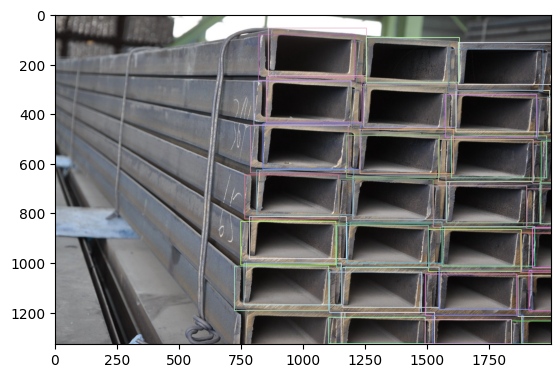

Кол-во труб на фото: 52


In [ ]:
img_path = 'example.jpg' # Path to image
pipe_type = 3 # Pipe profile type

result_img, num = process_image(img_path, pipe_type)

plt.imshow(result_img)
plt.show()
print('Number of pipes in the photo:', num)